In [1]:
import importlib

required_libraries = ['tensorflow', 'cv2', 'numpy', 'matplotlib', 'gradio']
missing_libraries = []

for lib in required_libraries:
    try:
        # cv2 is part of opencv-python but imported as 'cv2'
        importlib.import_module(lib if lib != 'cv2' else 'cv2')
        print(f"✅ {lib} is installed.")
    except ImportError:
        print(f"❌ {lib} is NOT installed.")
        missing_libraries.append(lib)

if missing_libraries:
    print("\nYou can install the missing libraries using:")
    print(f"!pip install {' '.join(missing_libraries)}")
else:
    print("\n🎉 All required libraries are installed!")


✅ tensorflow is installed.
✅ cv2 is installed.
✅ numpy is installed.
✅ matplotlib is installed.
✅ gradio is installed.

🎉 All required libraries are installed!


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
def load_data(data_dir):
    categories = ['NORMAL', 'PNEUMONIA']
    data = []
    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            try:
                image = cv2.imread(img_path)
                image = cv2.resize(image, (150, 150))
                data.append((image, label))
            except:
                continue
    return data

# Load data
train_data = load_data("chest_xray/train")
val_data = load_data("chest_xray/val")
test_data = load_data("chest_xray/test")

# Shuffle and unpack
np.random.shuffle(train_data)
x_train, y_train = zip(*train_data)
x_train = np.array(x_train)
y_train = to_categorical(y_train)

x_val, y_val = zip(*val_data)
x_val = np.array(x_val)
y_val = to_categorical(y_val)

x_test, y_test = zip(*test_data)
x_test = np.array(x_test)
y_test = to_categorical(y_test)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


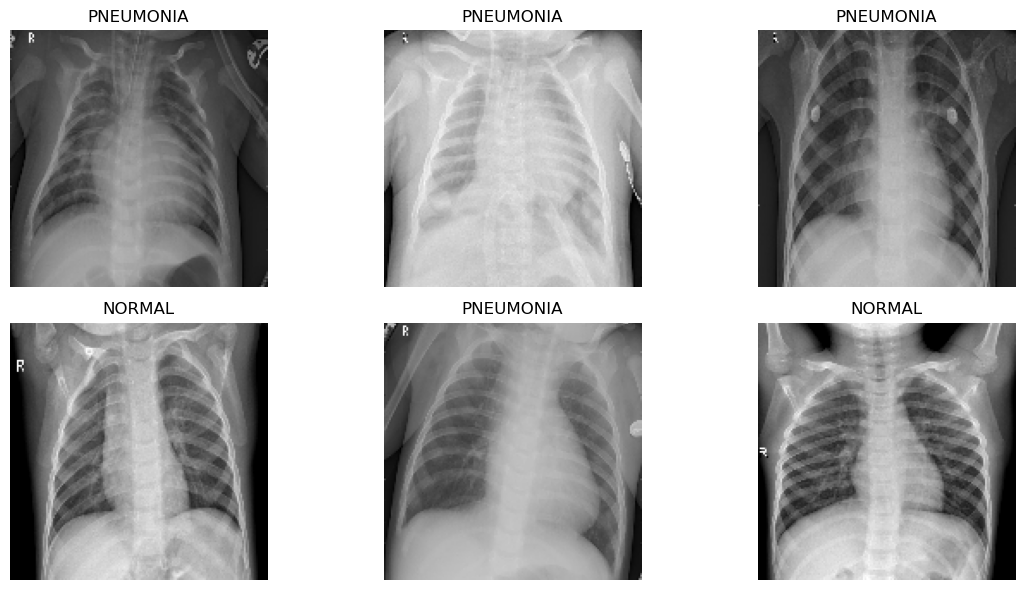

In [27]:
# Display sample images
def display_sample_images(data, num_images=6):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image, label = data[i]
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("PNEUMONIA" if label == 1 else "NORMAL")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(train_data)


In [28]:
# Model architecture
def build_model(filters=64, kernel_size=3, dropout_rate=0.4, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters * 2, (kernel_size, kernel_size), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
model = build_model()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)



In [29]:
# Train model
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(x_val, y_val),
    epochs=19,
    callbacks=[early_stopping, lr_scheduler]
)




Epoch 1/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7282 - loss: 3.8355 - val_accuracy: 0.5000 - val_loss: 155.9271 - learning_rate: 0.0010
Epoch 2/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8254 - loss: 0.5100 - val_accuracy: 0.5000 - val_loss: 110.0297 - learning_rate: 0.0010
Epoch 3/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8569 - loss: 0.4203 - val_accuracy: 0.5000 - val_loss: 20.2148 - learning_rate: 0.0010
Epoch 4/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8595 - loss: 0.3808 - val_accuracy: 0.6250 - val_loss: 1.3357 - learning_rate: 0.0010
Epoch 5/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8797 - loss: 0.2993 - val_accuracy: 0.6250 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 6/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.8724 - loss: 0.2895 - val_accuracy: 0.6250 - val_loss: 0.7947 - learning_rate: 0.0010
Epoch 7/19
163/163 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.8895 - los

In [30]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_datagen.flow(x_test, y_test), verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 84.94%


624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


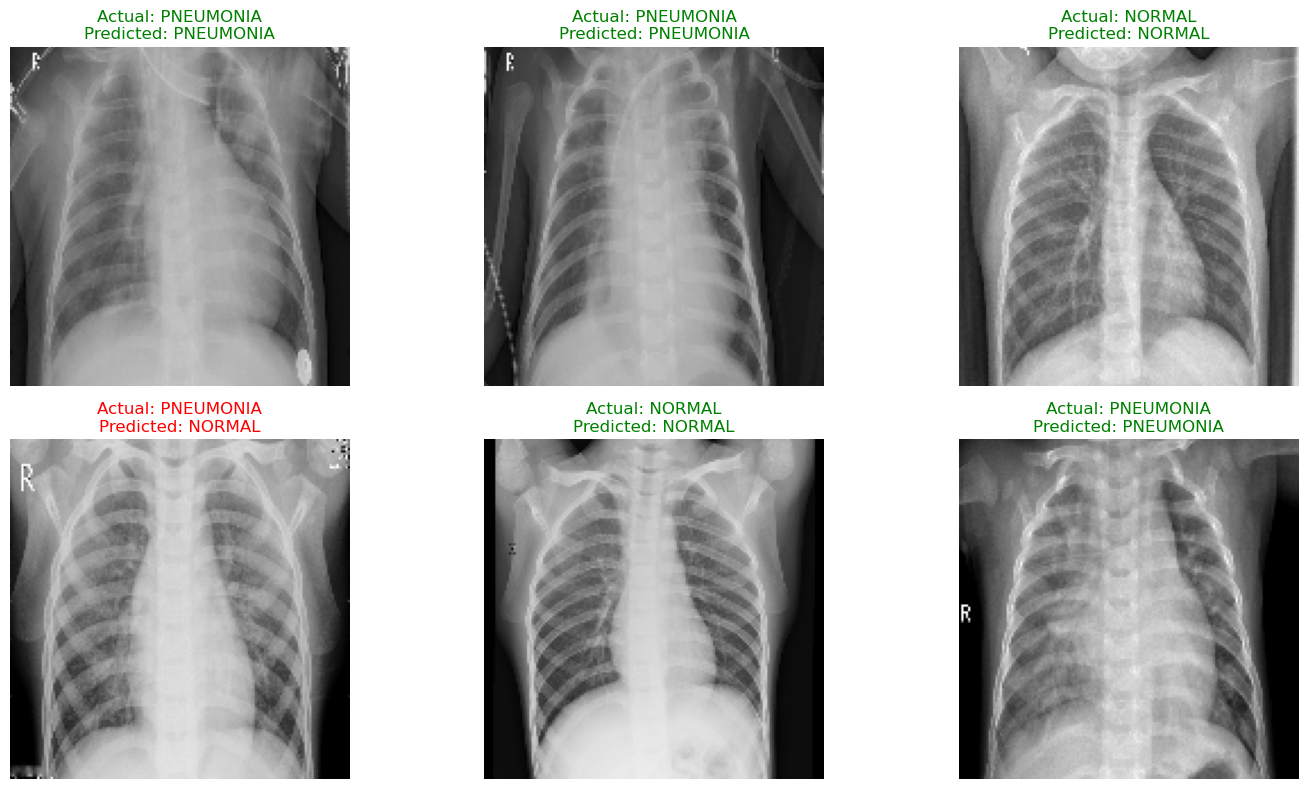

In [32]:
import random

# Class labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Predict on test data
y_pred_probs = model.predict(test_datagen.flow(x_test, shuffle=False, batch_size=1))
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Show random predictions
def show_predictions(num_images=6):
    indices = random.sample(range(len(x_test)), num_images)
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img = x_test[idx] / 255.0  # Rescale for visualization
        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred[idx]]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color='green' if true_label == pred_label else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
show_predictions()


In [33]:
model.save("pneumonia_cnn_model.h5")

In [3]:
# Evaluate on test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Normalize test set
x_test = x_test / 255.0
y_test_labels = np.argmax(y_test, axis=1)

# Predict probabilities
y_pred_probs = model.predict(x_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels)
recall = recall_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

NameError: name 'x_test' is not defined